In [3]:
#import libraries

import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec,KeyedVectors
from gensim.test.utils import datapath
import re
import unicodedata
from tqdm import tqdm
import gensim
import multiprocessing
import random
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from time import time
import tensorflow as tf
from absl import logging
import tensorflow_hub as hub
import os
import seaborn as sns

Let's Create our Model and Build Vocabulary!

In [76]:
#creating pandas series

data = pd.read_csv('open_ave_data.csv')
exname = data['ExamName']
clin =data['clinicaldata'].dropna()
find=data['findings']
imp =data['impression']

In [77]:
#creating sentences lists for each section

stopwords_list=stopwords.words('english')

exname_sentences = []
for w in exname:
    w=w.lower()
    w=re.sub(r'[^\w\s]','',w)
    w=re.sub(r"([0-9])", r" ",w)
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    exname_sentences.append(" ".join(clean_words))

clin_sentences = []
for w in clin:
    w=w.lower()
    w=re.sub(r'[^\w\s]','',w)
    w=re.sub(r"([0-9])", r" ",w)
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    clin_sentences.append(" ".join(clean_words))

find_sentences = []
for w in find:
    w=w.lower()
    w=re.sub(r'[^\w\s]','',w)
    w=re.sub(r"([0-9])", r" ",w)
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    find_sentences.append(" ".join(clean_words))

imp_sentences = []
for w in imp:
    w=w.lower()
    w=re.sub(r'[^\w\s]','',w)
    w=re.sub(r"([0-9])", r" ",w)
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    imp_sentences.append(" ".join(clean_words))

In [78]:
#Splitting Sentences by Words

def split_sentences(sentences):
    split_sentences = []
    for sentence in sentences:
        split_sentences.append(sentence.split())
    return split_sentences


exname=split_sentences(exname_sentences)
clin=split_sentences(clin_sentences)
find=split_sentences(find_sentences)
imp=split_sentences(imp_sentences)
full = exname+clin+find+imp

In [79]:
#Let's create the model

cores= multiprocessing.cpu_count()
model = Word2Vec(min_count=5,window=5,vector_size=300,workers=cores-1,max_vocab_size=100000)

In [80]:
#building the vocabulary

model.build_vocab(full)
len(model.wv)

392

In [81]:
model.wv.key_to_index.keys()

dict_keys(['chest', 'exam', 'normal', 'findings', 'comparison', 'impression', 'view', 'none', 'pleural', 'pneumothorax', 'history', 'effusion', 'technique', 'clinical', 'acute', 'date', 'personalname', 'heart', 'radiography', 'signed', 'mediastinum', 'within', 'focal', 'views', 'lungspleura', 'opacities', 'pain', 'cardiomediastinal', 'lungs', 'electronically', 'evident', 'cough', 'unremarkable', 'single', 'dictated', 'size', 'mediastinal', 'cardiopulmonary', 'contour', 'datetime', 'pulmonary', 'abnormality', 'contours', 'limitations', 'clear', 'disease', 'limits', 'breath', 'portable', 'shortness', 'silhouette', 'lateral', 'consolidation', 'osseous', 'stable', 'volumes', 'process', 'tube', 'two', 'lung', 'significant', 'right', 'structures', 'left', 'dated', 'effusions', 'evidence', 'infiltrate', 'indication', 'mild', 'cardiac', 'atelectasis', 'negative', 'fever', 'data', 'adenopathy', 'seen', 'frontal', 'visualized', 'bony', 'xray', 'tip', 'available', 'congestion', 'active', 'vessels

Training the Model

In [82]:
model.train(full,total_examples=model.corpus_count,epochs=50)


(842535, 1798100)

In [83]:
model.save('openave_word2vec_model')

Using the trained model

In [84]:
trained_model = gensim.models.Word2Vec.load('openave_word2vec_model')

In [85]:
vectors=[]
for i in full:
    vectors.append(model.wv.get_mean_vector(i))
    

In [86]:
len(vectors)

3812

In [87]:
vectors[0].shape

(300,)

In [88]:
vectors = np.array(vectors)

In [89]:
vectors.shape

(3812, 300)

In [90]:
#Create embeddings in 2d space
X_embed = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3,random_state=50).fit_transform(vectors)

In [91]:
X_embed.shape

(3812, 2)

In [93]:
len(exname), len(clin), 954+950

(954, 950, 1904)

In [95]:
 1904 + len(find)

2858

In [ ]:
 len(imp)

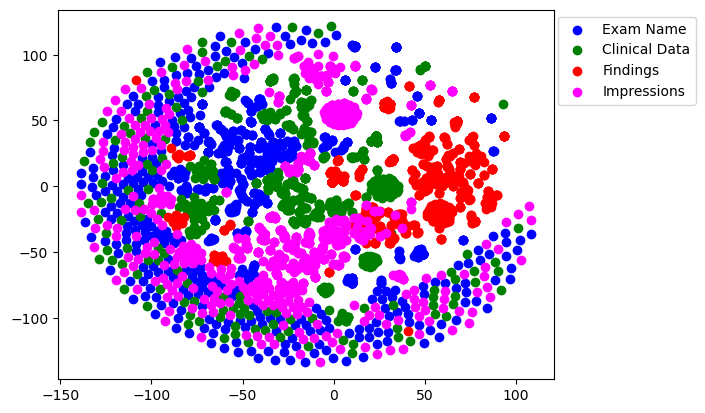

In [112]:
#Exam Name in blue
plt.scatter(X_embed[0:954,0],X_embed[0:954,1],c='blue',label='Exam Name')

#Clinical data in green
plt.scatter(X_embed[954:1904,0],X_embed[954:1904,1],c='green',label='Clinical Data')

#Findings in red
plt.scatter(X_embed[1904:2858,0],X_embed[1904:2858,1],c='red',label='Findings')

#And Impressions in magenta
plt.scatter(X_embed[2858:,0],X_embed[2858:,1],c='magenta',label='Impressions')

plt.legend(loc='best', bbox_to_anchor=(.8, .5, 0.5, 0.5))

Exam Name has a few main clusters with a large overall spread in the graph. Clinical data has a few small clusters, demonstrating that there are a few main types of clinical histories that are sending patients to pursue radiology services. Findings has the smallest spread, showing distinct data in the findings section.Impressions appears to have a few main clusters of varying sizes and a few outliers.

***Compare/Contrast with tf-idf***
Similarly to tf-idf vectorization, the report findings are largely clustered around each other with few outliers. Impressions has several clusters as well as some outliers, and its spread is greater in word2vec compared to tf-idf. Exam Name is more clustered in tf-idf than in word2vec, and Clinical Data shows more distinct clusters in word2vec than in tf-idf, where Clinical Data appears to be clustered but with a greater overall spread amongst distinct clusters. In general, word2vec has more distinct clusters while tf-idf has fewer distinct clusters.

Logistic Regression

In [99]:
y = np.empty(X_embed.shape[0])
y[0:954] = 0
y[954:1904] = 1
y[1904:2858] = 2
y[2858:X_embed.shape[0]] = 3

X = vectors
X.shape, y.shape


((3812, 300), (3812,))

In [100]:
#Splitting our dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=.33, shuffle=True, random_state=52
)

In [101]:
#Logistic Regression

lr_model = LogisticRegression(max_iter=10000)
param_dict = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
             'solver': ['liblinear','sag', 'lbfgs', 'saga']}

start = time()
grid_search = GridSearchCV(lr_model, param_dict)
grid_search.fit(X_train, y_train)
print("GridSearch took %.2f seconds to complete." % (time()-start))
display(grid_search.best_params_)
print("Cross-Validated Score of the Best Estimator: %.3f" % grid_search.best_score_)

GridSearch took 99.75 seconds to complete.


{'C': 100, 'solver': 'liblinear'}

Cross-Validated Score of the Best Estimator: 0.996


In [102]:
lr=LogisticRegression(C=100, solver ='liblinear')
lr.fit(X_train, y_train)
lr_preds=lr.predict(X_test)

print(confusion_matrix(y_test, lr_preds))
print(classification_report(y_test, lr_preds))
print("Accuracy Score: %.3f" % accuracy_score(y_test, lr_preds))

[[330   0   0   0]
 [  0 311   0   0]
 [  0   0 318   0]
 [  0   0   0 299]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       330
         1.0       1.00      1.00      1.00       311
         2.0       1.00      1.00      1.00       318
         3.0       1.00      1.00      1.00       299

    accuracy                           1.00      1258
   macro avg       1.00      1.00      1.00      1258
weighted avg       1.00      1.00      1.00      1258

Accuracy Score: 1.000


This regression model appears to be more accurate than the one based on tf-idf vectorization. An accuracy score of 1 is very high and new data could produce a lower level of accuracy. Additionally, this model used a C of 100 and the liblinear solver, whereas the tf-idf-based regression model called for C=100 and the sag solver. The specified random state of 52 in both models could also be affecting the regression results in both cases, and other random states (specified or unspecified) could produce more varied results. One limitation of word2vec is that the library is optimized for analyzing word embeddings more so than sentence embeddings. To further explore sentences, we will use TensorFlow and Google's Universal Sentence Encoder to explore classification *that* way.

In [166]:
# Load the Universal Sentence Encoder's TF Hub module

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [168]:
# One of the advantages of Universal Sentence Encoder is that sentences do not need to be modified as much.

exname0 = data['ExamName']
clin0 =data['clinicaldata'].dropna()
find0=data['findings']
imp0 =data['impression']

In [212]:
exname0_sentences = []
for w in exname0:
    exname0_sentences.append(w)

clin0_sentences = []
for w in clin0:
    clin0_sentences.append(w)

find0_sentences = []
for w in find0:
    find0_sentences.append(w)

imp0_sentences = []
for w in imp0:
    imp0_sentences.append(w)

len(exname0_sentences),len(clin0_sentences),len(find0_sentences),len(imp0_sentences)

(954, 950, 954, 954)

In [213]:
#merging the lists

sentences_list = []

my_lists = [exname0_sentences,clin0_sentences,find0_sentences,imp0_sentences]

for v in my_lists:
    for i in v:
        sentences_list.append(i)

len(sentences_list)

3812

In [ ]:
 = tf.convert_to_tensor(new_list)

In [219]:
# Reduce logging output.

logging.set_verbosity(logging.ERROR)

messages=sentences_list

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: EXAM: CHEST RADIOGRAPHY EXAM DATE: 06/01/2019 08:30 PM.

TECHNIQUE: 2 views.

COMPARISON: None.
Embedding size: 512
Embedding: [-0.04912470653653145, -0.08492368459701538, -0.030449897050857544, ...]

Message: EXAM: CHEST RADIOGRAPHY EXAM DATE: 05/23/2020 12:03 PM.

TECHNIQUE: 1 view.

COMPARISON: XR CHEST 2V AP/PA AND LAT 11/24/2019 9:30 PM.
Embedding size: 512
Embedding: [-0.012607852928340435, -0.07051263004541397, -0.019535990431904793, ...]

Message: EXAM: CHEST RADIOGRAPHY EXAM DATE: 12/13/2019 03:40 PM.

TECHNIQUE: 2 views.

COMPARISON: XR RIBS LEFT W PA CHEST 12/12/2019 1:57 PM.
Embedding size: 512
Embedding: [-0.039890024811029434, -0.046872131526470184, 0.007458834908902645, ...]

Message: Exam: - CHEST-PORTABLE

Comparison: None
Embedding size: 512
Embedding: [-0.06004396080970764, -0.08761895447969437, 0.004399260506033897, ...]

Message: EXAM: CHEST RADIOGRAPHY EXAM DATE: 06/17/2021 03:09 PM.

TECHNIQUE: 1 view.

COMPARISON: XR CHEST AP PORTABLE 06/20/2021 9:37 AM

In [222]:
len(message_embedding)

512

In [232]:
message_embeddings

<tf.Tensor: shape=(3812, 512), dtype=float32, numpy=
array([[-0.04912471, -0.08492368, -0.0304499 , ..., -0.05031916,
        -0.01080786, -0.0421611 ],
       [-0.01260785, -0.07051263, -0.01953599, ..., -0.02697495,
         0.04422589, -0.07516107],
       [-0.03989002, -0.04687213,  0.00745883, ..., -0.0386132 ,
         0.01375441, -0.0738873 ],
       ...,
       [-0.01813122, -0.05021499, -0.06405164, ...,  0.04054179,
         0.03867765, -0.00152949],
       [-0.05063188, -0.05413073,  0.02194048, ...,  0.05231306,
        -0.03733223,  0.0019266 ],
       [-0.01178739,  0.00454524,  0.0427921 , ..., -0.0131797 ,
        -0.07323317,  0.05500354]], dtype=float32)>

In [233]:
#Create embeddings in 2d space

X_embed0 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3,random_state=50).fit_transform(message_embeddings)
X_embed0

array([[ 48.11122  , -15.805102 ],
       [-45.18737  ,   1.7880882],
       [ 10.693994 ,  39.96469  ],
       ...,
       [  4.274199 ,  62.486526 ],
       [-35.49581  ,  90.94997  ],
       [ 11.038999 ,  -6.4237046]], dtype=float32)

In [234]:
X_embed0.shape

(3812, 2)

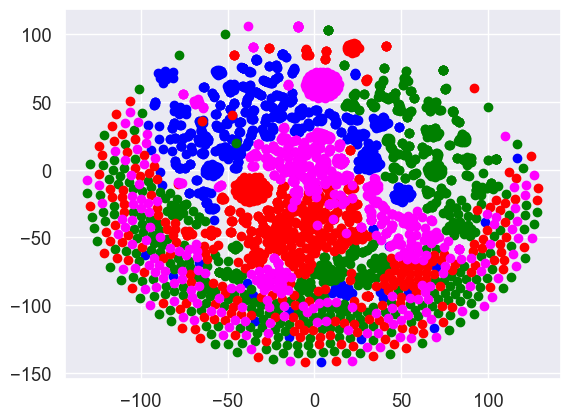

In [236]:
#Exam Name in blue
plt.scatter(X_embed0[0:954,0],X_embed0[0:954,1],c='blue')

#Clinical data in green
plt.scatter(X_embed0[954:1904,0],X_embed0[954:1904,1],c='green')

#Findings in red
plt.scatter(X_embed0[1904:2858,0],X_embed0[1904:2858,1],c='red')

#And Impressions in magenta
plt.scatter(X_embed0[2858:,0],X_embed0[2858:,1],c='magenta')

In [240]:
X = np.array(message_embeddings)
y = np.empty(X.shape[0])
y[0:954] = 0
y[954:1904] = 1
y[1904:2858] = 2
y[2858:X.shape[0]] = 3

X.shape, y.shape

((3812, 512), (3812,))

In [241]:
#Splitting our dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=.33, shuffle=True, random_state=52
)

In [242]:
#Logistic Regression

lr_model = LogisticRegression(max_iter=2000)
param_dict = {'C': [0.001, 0.01, 0.1, 1, 10,100],
             'solver': ['liblinear','sag', 'lbfgs', 'saga']}

start = time()
grid_search = GridSearchCV(lr_model, param_dict)
grid_search.fit(X_train, y_train)
print("GridSearch took %.2f seconds to complete." % (time()-start))
display(grid_search.best_params_)
print("Cross-Validated Score of the Best Estimator: %.3f" % grid_search.best_score_)

GridSearch took 179.37 seconds to complete.


{'C': 100, 'solver': 'liblinear'}

Cross-Validated Score of the Best Estimator: 1.000


In [243]:
lr=LogisticRegression(C=100, solver ='liblinear',max_iter=2000)
lr.fit(X_train, y_train)
lr_preds=lr.predict(X_test)

print(confusion_matrix(y_test, lr_preds))
print(classification_report(y_test, lr_preds))
print("Accuracy Score: %.3f" % accuracy_score(y_test, lr_preds))

[[330   0   0   0]
 [  0 311   0   0]
 [  2   0 316   0]
 [  0   0   1 298]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       330
         1.0       1.00      1.00      1.00       311
         2.0       1.00      0.99      1.00       318
         3.0       1.00      1.00      1.00       299

    accuracy                           1.00      1258
   macro avg       1.00      1.00      1.00      1258
weighted avg       1.00      1.00      1.00      1258

Accuracy Score: 0.998
